In [1]:
import pandas as pd
import sqlite3
from matplotlib import pyplot as plt
pd.set_option('display.max_rows',1000)

In [2]:
try:
    conn = sqlite3.connect("../data/cruise_pre.db")
    conn2 = sqlite3.connect("../data/cruise_post.db")
except Exception as e:
    print(e)

#Now in order to read in pandas dataframe we need to know table name
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(f"Table Name : {cursor.fetchall()}")

cursor = conn2.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(f"Table Name : {cursor.fetchall()}")

df = pd.read_sql_query('SELECT * FROM cruise_pre', conn)
df2 = pd.read_sql_query('SELECT * FROM cruise_post', conn2)
conn.close()
conn2.close()

Table Name : [('cruise_pre',)]
Table Name : [('cruise_post',)]


In [3]:
#
# check what columns there are and the column name spellings
# data type of each column
# check number of rows
#

for c in df.columns:
    print(c,":",df[c].dtype)
print(df.shape)

print("\n")
for c in df2.columns:
    print(c, ":", df2[c].dtype)

print(df2.shape)

index : int64
Gender : object
Date of Birth : object
Source of Traffic : object
Onboard Wifi Service : object
Embarkation/Disembarkation time convenient : float64
Ease of Online booking : float64
Gate location : float64
Logging : object
Onboard Dining Service : object
Online Check-in : float64
Cabin Comfort : float64
Onboard Entertainment : object
Cabin service : float64
Baggage handling : float64
Port Check-in Service : float64
Onboard Service : float64
Cleanliness : float64
Ext_Intcode : object
(133746, 19)


index : int64
Cruise Name : object
Ticket Type : object
Cruise Distance : object
Ext_Intcode : object
WiFi : float64
Dining : int64
Entertainment : float64
(133746, 8)


## Check for data that may not be suitable - Cruise_Pre

1. Check for columns that do not seem to affect outcome of ticket type and make a note to remove them during data cleaning.
2. These are 'Source of Traffic', 'Embarkation/Disembarkation time convenient',
            'Ease of Online booking', 'Gate location', 'Logging'
3. Check for rows with duplicated ExtIntcode. Decide how to remove these duplicated ones during data cleaning



In [4]:
#
# the following columns do not seem to have a causal relationship with target column.
# wil drop them during data cleaning
#
drop_cols = ['Source of Traffic', 'Embarkation/Disembarkation time convenient',
            'Ease of Online booking', 'Gate location', 'Logging']
#df.drop(drop_cols ,axis=1, inplace=True)

In [17]:
#
# check for duplicates in Ext_Intcode. This is the unique identifier, so we need to ensure no duplicates
# will remove duplicated ones during data cleaning by removing the ones with more null values
# removing these duplicates, we have still have about 130000 rows. The impact is not significant
#
print(df[df['Ext_Intcode'].duplicated()].shape)
print(df2[df2['Ext_Intcode'].duplicated()].shape)

(3896, 19)
(3896, 8)


## Cruise_Pre EDA

The following cells is the check for null values.
We need to find ways to handle null values to have clean data for training.
The ways we handle null values should be different depending on the columns.
We should try to derive null values as much as possible as removing them means we have less data for training

1. In data cleaning stage, will remove rows that have null values in gender or date of birth columns as there is no way of filling them with meaningful data
2. There are invalid values in DOB (year=18xx) that we will drop as well. DOB can use to determine age which can be used as a feature
3. As for categorical columns ['Onboard Wifi Service','Onboard Dining Service', 'Online Check-in', 
            'Cabin Comfort','Onboard Entertainment', 'Cabin service', 'Baggage handling',
            'Port Check-in Service', 'Onboard Service', 'Cleanliness'],
    Most have nan values and some have invalid value - 0. 
    the null or invalid values (0) are treated as 'N_A' as null values most likely indicate that the respondent didn't answer this question which could most likely mean they have no opinion on that or its not applicable to them. So we create another category 'N_A' or 0 to handle it


In [20]:
# check the number of null values in each column

# it seems we have about 10%-15% of null values for each column.  If they are uniquely different, removing
# the rows will mean that we might be left with very little data for training. So we should analyze each column
# to decide how to fillna as much as possible

cnt=0
for c in df.columns:
    print(c,":", df[df[c].isna()].shape)
    cnt = cnt + df[df[c].isna()].shape[0]
print("TOTAL NULL", cnt)

index : (0, 19)
Gender : (13456, 19)
Date of Birth : (14684, 19)
Source of Traffic : (0, 19)
Onboard Wifi Service : (19492, 19)
Embarkation/Disembarkation time convenient : (15643, 19)
Ease of Online booking : (18355, 19)
Gate location : (17140, 19)
Logging : (0, 19)
Onboard Dining Service : (16809, 19)
Online Check-in : (15687, 19)
Cabin Comfort : (20252, 19)
Onboard Entertainment : (15913, 19)
Cabin service : (13832, 19)
Baggage handling : (20293, 19)
Port Check-in Service : (14347, 19)
Onboard Service : (18327, 19)
Cleanliness : (18402, 19)
Ext_Intcode : (0, 19)
TOTAL NULL 252632


In [43]:
#
# Gender column. Check what categories there are / there could be mis-spellings
# We ascertain that besides null values there is only Male and Female. So we just need to handle null values in data cleaning
#
print(df['Gender'].unique())

[None 'Female' 'Male']


In [44]:
#
# Date of Birth. Check for the type for this column and whether format is consistent.
# Also check for dates that may be impossible - future date / ancient dates
#
print(*(list(df[df['Date of Birth'].isna()==False]['Date of Birth'].unique())))
#
# check if all are DD/MM/YYY 
#
print(df[df['Date of Birth'].str.contains("/")==False]['Date of Birth'].sample(5))
#
# it seems some are YYYY-MM-DD
#
# get the year of birth and determine if some are future or ancient. In data cleaning remove those earlier than 1920 and those in future years
# despite the huge number (13%) in null + invalid in date of birth, they need to be removed as this is unusable
#
dfx = df[df['Date of Birth'].isna()==False].copy()
dfx['YOB'] = dfx.apply(lambda x: int(x['Date of Birth'].split("/")[-1]) if "/" in x['Date of Birth']
                                 else int(x['Date of Birth'].split("-")[0]), axis=1)
print(dfx[dfx['YOB']>2023].shape)
print(dfx[dfx['YOB']<1920].shape)

05/10/1973 22/07/1998 01/05/1970 07/01/1960 23/12/1986 20/03/1987 20/12/1981 26/07/1980 13/05/2008 19/03/1989 08/05/2000 20/08/1989 17/07/1987 08/06/1976 01/11/1971 21/06/1969 07/08/1975 16/10/1965 01/01/1982 22/02/1984 03/12/1977 05/01/2004 12/12/1964 02/09/1978 19/04/1979 12/03/1987 22/07/1981 28/09/1957 16/03/1998 10/05/1978 15/03/1977 06/11/1994 23/09/2009 23/07/1994 05/01/1972 20/10/2015 24/03/2002 13/07/1985 09/11/1991 02/01/1999 15/11/1987 11/01/1970 21/10/2008 28/08/1992 07/09/2009 08/04/1979 17/02/1981 06/08/1996 09/10/1972 06/08/1962 03/04/1984 22/11/1993 11/01/1960 20/04/2002 07/08/2002 17/05/1983 04/09/2001 25/05/1984 22/06/1983 18/06/1971 23/09/2000 16/08/1974 17/01/1967 12/06/1964 15/06/1975 16/08/1972 28/06/1998 27/06/1961 21/10/2009 03/04/1976 24/02/1959 28/11/2015 06/03/1997 25/04/1998 16/09/1986 13/01/1961 21/07/1963 1897-05-13 07/01/1988 06/07/1993 28/08/1971 1864-10-10 07/02/1980 06/09/2003 08/02/1992 01/10/1975 10/07/1963 28/06/1990 17/03/2015 11/08/1989 13/10/1974

max    85
min     7
Name: age, dtype: int64


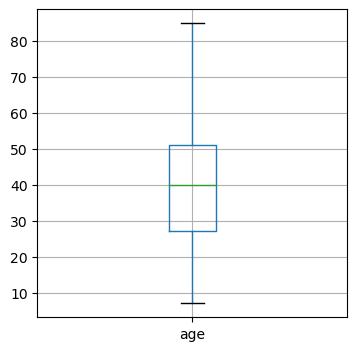

<Axes: ylabel='Frequency'>

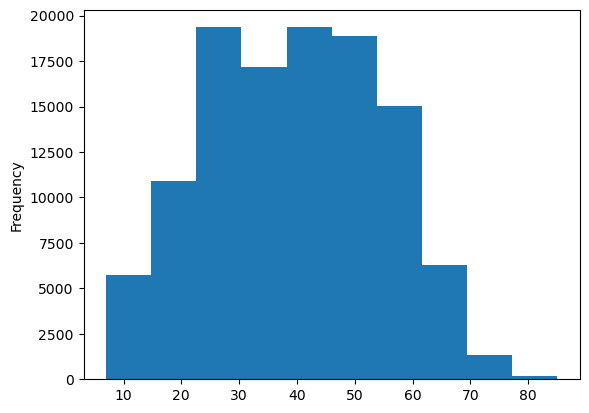

In [46]:
# we want to feature engineer age from DOB and bin the ages. Plot a histogram and box plot to check on how to split
#
dfx = dfx[dfx['YOB']>1920]
dfx['age'] = dfx.apply(lambda x: 2023-x['YOB'], axis=1)

print(dfx['age'].agg(['max', 'min']))

dfx.boxplot(column=['age'], figsize=(4,4))
plt.show()

dfx['age'].plot(kind='hist')

#
# based on the plots, we can split 25, 35,45, 55
#

In [4]:
#
# review the categories in the categorical columns
# it is noted that besides nan, there are also invalid values ie, 0
# in data cleaning we treat nan to be the same as 0 and assign them a category of 'N_A' or 0 to indicate no opinion
# There does not seem to be a better way to fillna as we are not sure why the respondent left it blank
#
cat_cols = ['Onboard Wifi Service','Onboard Dining Service', 'Online Check-in', 
            'Cabin Comfort','Onboard Entertainment', 'Cabin service', 'Baggage handling',
            'Port Check-in Service', 'Onboard Service', 'Cleanliness']

for c in cat_cols:
    print(c, ":", df[c].unique())

Onboard Wifi Service : ['A little important' 'Not at all important' None 'Very important'
 'Somewhat important' 'Extremely important']
Onboard Dining Service : ['Very important' None 'Somewhat important' 'Not at all important'
 'A little important' 'Extremely important']
Online Check-in : [ 2. nan  4.  1.  0.  5.  3.]
Cabin Comfort : [ 2.  4.  5. nan  1.  3.  0.]
Onboard Entertainment : ['A little important' None 'Extremely important' 'Not at all important'
 'Very important' 'Somewhat important']
Cabin service : [ 2. nan  3.  5.  4.  1.  0.]
Baggage handling : [ 2.  3.  1. nan  4.  5.]
Port Check-in Service : [ 4.  2.  3.  5.  1. nan]
Onboard Service : [ 2.  4.  3. nan  5.  1.  0.]
Cleanliness : [ 3.  4. nan  1.  2.  5.  0.]


## Cruise_post EDA
1. Cruise Name mis-spellings or short forms. In data cleaning will standardize these to only 2 cruise names - Blastoise and Lapras. However, if we have the opportunity, we should seek clarification from business owner / team as this is easy to clarify
   In data cleaning, the null values according to ratios of these 2 names.
2. Ticket Type is our target column so should not have any null values. In data cleaning remove rows with null Ticket Type. However if it is not too labourious an exercise and we can still trace back with the internal code, we can verify ticket type. In addition, there is class imbalance where the Deluxe class has much fewer samples. We can consider introducing weights into the model training
3. Distance is object type, have different units and some are negative - in data cleaning, we should fix all that and change it to numeric with standardized unit of KM and remove rows with null values. It may be possible to ascertain a more accurate Cruise Distance from business owner / team, as the cruises tend to be to a few fixed locations. 
4. Null values in WiFi and Entertainment. In data cleaning will fill it with 2 to indicate N_A - similar to cruise_pre, it could most likely indicate no opinion



In [21]:
# determine the number of null values in each column and the type of values in each column.

for c in df2.columns:
    if c == 'index' or c=='Ext_Intcode' or c=='num_na':
        continue
    print(c,":", df2[df2[c].isna()].shape, df2[c].unique(), "\n")

Cruise Name : (15931, 8) ['Blastoise' 'IAPRAS' 'Lapras' None 'blast' 'lap' 'blastoise' 'blast0ise'
 'lapras'] 

Ticket Type : (20061, 8) [None 'Deluxe' 'Standard' 'Luxury'] 

Cruise Distance : (14486, 8) ['3567 KM' '672 KM' '1167 KM' ... '3292 Miles' '-751 Miles' '2656 Miles'] 

WiFi : (69734, 8) [ 1. nan  0.] 

Dining : (0, 8) [1 0] 

Entertainment : (60057, 8) [ 1.  0. nan] 



Blastoise    69151
Lapras       31057
blast         3046
lapras        2955
blastoise     2917
blast0ise     2906
lap           2898
IAPRAS        2885
Name: Cruise Name, dtype: int64


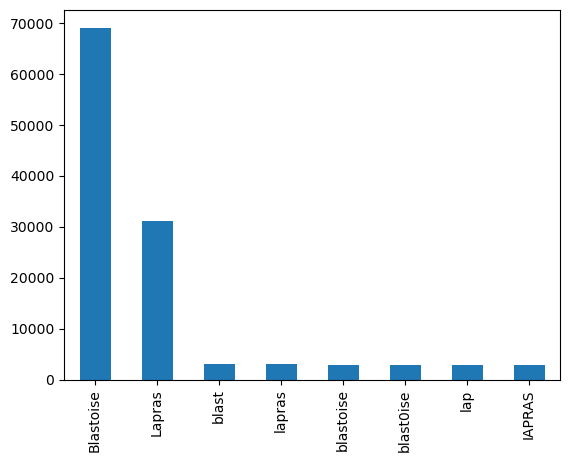

In [24]:
# plot the Cruise Names as blast0ise = blastoise = Blastoise & IAPRAS = Lapras = lapras

df2['Cruise Name'].value_counts().plot(kind='bar')
print(df2['Cruise Name'].value_counts())

# as the other names 'blast', 'blastoise' and 'blast0ise' seem signifcantly smaller, we can assume that they all refer to Blastoise.
# and likewise lapras, lap, IAPRAS indicate Lapras
# if given the opportunity can easily verify
# in data cleaning will narrow down to Lapras and Blastoise
# we then fill the null values with the either of the above by ratio


130962        337 KM
132100        596 KM
49865         471 KM
57340           None
123831        237 KM
54455         550 KM
47199         283 KM
109029    2045 Miles
63935       -2861 KM
132294        486 KM
15851         106 KM
102554        604 KM
30334         762 KM
87024        3077 KM
109396       1947 KM
75445           None
15587           None
81472        3682 KM
72496         403 KM
81694         867 KM
8723          528 KM
81144         363 KM
65587     1754 Miles
6202          406 KM
98272         599 KM
29323     2075 Miles
81359        1041 KM
79186           None
36442        2565 KM
117181        331 KM
105323          None
53007        1190 KM
9498          189 KM
49694         646 KM
15935     1860 Miles
100973        224 KM
41332        1635 KM
29733         164 KM
51750         646 KM
14195         315 KM
68012         131 KM
90403       -1189 KM
95728        3724 KM
47426           None
47459        1749 KM
80685       -3880 KM
16994         432 KM
44439        

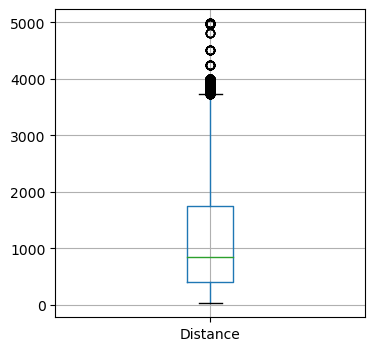

<Axes: ylabel='Frequency'>

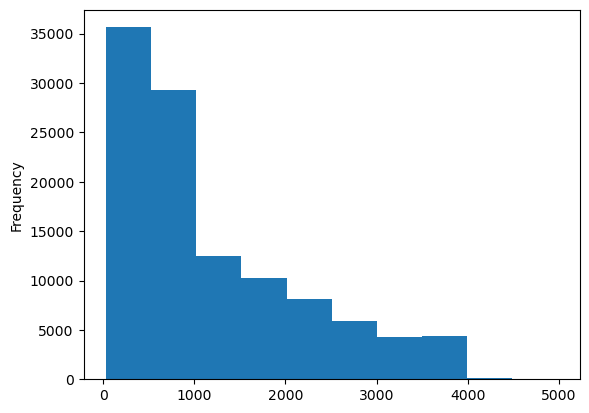

In [50]:
#
# From the sample, we see that Cruise Distance is of object type, we should convert this to float
# so that it can be used by ML meaningfully. Besides null, Cruise Distance has negative values and are in different units
# Cruise distance also has negative values.
# In data cleaning, need to ensure no negative values and standardize to KM. In data cleaning, rows with null distances should also be removed
# 
# Some values such as those below 100KM seem too short for a cruise. For this exercise we will keep it
# but this should be verified with business owner / team. 
# The box plot and histogram shows a right-skewed distribution, which indicate the need for verification
#
# We can consider to bin the values or normalize to make it to less varying. 
#

print(df2['Cruise Distance'].sample(50))
dfx = df2[df2['Cruise Distance'].isna()==False].copy()

dfx['Distance_type'] = dfx.apply(lambda x: x['Cruise Distance'].split(" ")[-1] 
                                 if x['Cruise Distance']!=None else x['Cruise Distance'], axis=1)

dfx['Distance'] = dfx.apply(lambda x: int(x['Cruise Distance'].split(" ")[0]) if x['Cruise Distance']!=None 
                            else x['Cruise Distance'], axis=1)

print("\n")
print(dfx['Distance'].agg(['min', 'max']))
print("\n")
print(dfx[dfx['Distance']>0]['Distance'].agg(['min', 'max']))
print("\n")
print(dfx[(dfx['Distance']>0) & (dfx['Distance']<100)].shape)
dfx[dfx['Distance']>0].boxplot(column=['Distance'], figsize=(4,4))
plt.show()
#df_merge['Distance'].plot(kind='hist')
dfx[dfx['Distance']>0]['Distance'].plot(kind='hist')


<Axes: >

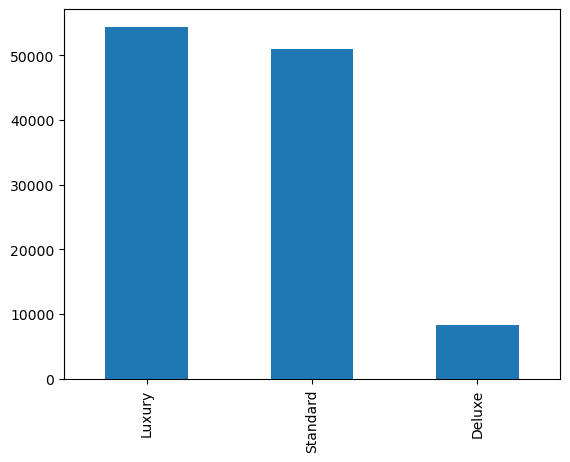

In [40]:
# 
# the data is skewed towards 0 & 2. This could cause the model to be bias towards the dataset with more training data
# we can consider introducing weights when training the models to counter the imbalance of the dataset
#
df2['Ticket Type'].value_counts().plot(kind='bar')